In [1]:
import pandas as pd
import deepchem as dc
import numpy as np
from tqdm import tqdm
import torch
import data_utils as HIVLoader
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

/home/daffaizzuddin/miniconda3/envs/interna/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-11 06:59:19.783934: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-11 06:59:20.414631: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


## Load Datasets

In [2]:
df = HIVLoader.load_main_data()
df.head()

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,False
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,False
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,False
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,False
4,O=S(=O)(O)CCS(=O)(=O)O,CI,False


## Data Preparation

In [3]:
train_ds, val_ds, test_ds = HIVLoader.scaffold_split(df)
print(f'total: {len(train_ds):5d}, active: {sum(train_ds.y):4d}, inactive: {sum(train_ds.y == False):5d}')
print(f'total: {len(val_ds):5d}, active: {sum(val_ds.y):4d}, inactive: {sum(val_ds.y == False):5d}')
print(f'total: {len(test_ds):5d}, active: {sum(test_ds.y):4d}, inactive: {sum(test_ds.y == False):5d}')

[06:59:28] WARNING: not removing hydrogen atom without neighbors
[06:59:28] WARNING: not removing hydrogen atom without neighbors


total: 28788, active: 1083, inactive: 27705
total:  8226, active:  217, inactive:  8009
total:  4113, active:  130, inactive:  3983


In [4]:
featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
transformer = dc.trans.FeaturizationTransformer(featurizer=featurizer)

train_feat = train_ds.transform(transformer)
val_feat = val_ds.transform(transformer)
test_feat = test_ds.transform(transformer)

[07:01:34] WARNING: not removing hydrogen atom without neighbors
[07:01:34] WARNING: not removing hydrogen atom without neighbors


## Modelling

In [5]:
from typing import Any

def print_dict(dictionary, sep=', '):
  result = [f'{k}: {v:.4f}' for k, v in dictionary.items()]
  print(sep.join(result))

def train_model(create_model, train_data, test_data, transformer, save_dir, epoch=20, batch_size=64):
  optimizer = dc.models.optimizers.Adam(0.001)
  model = create_model()
  
  metrics = [dc.metrics.Metric(metric) for metric in [roc_auc_score, f1_score, accuracy_score, recall_score]]
  best_metric = {
    'f1_score': float('-inf'),
    'roc_auc_score': float('-inf'),
    'recall_score': float('-inf')
  }
  
  for i in range(epoch):
    losses = []
    for X, y, w, _ in tqdm(train_data.iterbatches(batch_size), total=np.ceil(len(train_feat)/batch_size)):
      loss = model.fit_on_batch(X, y, w)
      losses.append(loss)
    
    result_metrics = model.evaluate(test_data, metrics, transformers=[transformer])
    result_metrics['train_loss'] = np.mean(np.array(losses))
    result_metrics['epoch'] = i
    
    for metric, value in best_metric.items():
      if result_metrics[metric] > value:
        best_metric[metric] = result_metrics[metric]
        model.save_checkpoint(1, os.path.join(save_dir, f'best_{metric}'))
    
    print_dict(result_metrics)
  
  best_model = {}
  for metric, score in best_metric.items():
    _model = create_model()
    _model.restore(os.path.join(save_dir, f'best_{metric}', 'checkpoint1.pt'))
    best_model[metric] = (_model, score)
    
  return best_model

def evaluate_model(model, dataset):
  metrics = [dc.metrics.Metric(metric) for metric in [roc_auc_score, f1_score, accuracy_score, recall_score]]
  result_metrics = model.evaluate(dataset, metrics, transformers=[transformer])
  
  logits = model.predict(dataset, transformers=[transformer])
  preds = np.argmax(logits, axis=1)

  cm = confusion_matrix(test_feat.y, preds, normalize='true')
  disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm)
  
  cm = confusion_matrix(test_feat.y, preds)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  
  return result_metrics, (disp, disp_norm)

### Graph Convolution Model

In [6]:
gcn_model = lambda optimizer=None: dc.models.GCNModel(
  mode='classification',
  n_tasks=1,
  learning_rate=0.001,
  device=torch.device('cuda'),
  optimizer=optimizer
)
best_gcn_model = train_model(gcn_model, train_feat, val_feat, transformer, save_dir='checkpoints/GCM')

100%|██████████| 450/450.0 [00:28<00:00, 15.68it/s]


roc_auc_score: 0.7138, f1_score: 0.0805, accuracy_score: 0.5669, recall_score: 0.7189, train_loss: 0.8063, epoch: 0.0000


100%|██████████| 450/450.0 [00:27<00:00, 16.21it/s]


roc_auc_score: 0.7024, f1_score: 0.0615, accuracy_score: 0.3132, recall_score: 0.8525, train_loss: 0.7639, epoch: 1.0000


100%|██████████| 450/450.0 [00:27<00:00, 16.27it/s]


roc_auc_score: 0.7341, f1_score: 0.1309, accuracy_score: 0.7902, recall_score: 0.5991, train_loss: 0.7210, epoch: 2.0000


100%|██████████| 450/450.0 [00:27<00:00, 16.66it/s]


roc_auc_score: 0.7269, f1_score: 0.1858, accuracy_score: 0.9041, recall_score: 0.4147, train_loss: 0.6902, epoch: 3.0000


100%|██████████| 450/450.0 [00:28<00:00, 16.07it/s]


roc_auc_score: 0.7449, f1_score: 0.0734, accuracy_score: 0.4688, recall_score: 0.7972, train_loss: 0.6637, epoch: 4.0000


100%|██████████| 450/450.0 [00:28<00:00, 15.92it/s]


roc_auc_score: 0.7401, f1_score: 0.1210, accuracy_score: 0.7705, recall_score: 0.5991, train_loss: 0.6489, epoch: 5.0000


100%|██████████| 450/450.0 [00:27<00:00, 16.62it/s]


roc_auc_score: 0.7297, f1_score: 0.1130, accuracy_score: 0.7691, recall_score: 0.5576, train_loss: 0.6253, epoch: 6.0000


100%|██████████| 450/450.0 [00:27<00:00, 16.44it/s]


roc_auc_score: 0.7416, f1_score: 0.1801, accuracy_score: 0.8816, recall_score: 0.4931, train_loss: 0.6121, epoch: 7.0000


100%|██████████| 450/450.0 [00:28<00:00, 15.97it/s]


roc_auc_score: 0.7403, f1_score: 0.1103, accuracy_score: 0.7215, recall_score: 0.6544, train_loss: 0.5959, epoch: 8.0000


100%|██████████| 450/450.0 [00:27<00:00, 16.28it/s]


roc_auc_score: 0.7567, f1_score: 0.1325, accuracy_score: 0.7851, recall_score: 0.6221, train_loss: 0.5685, epoch: 9.0000


100%|██████████| 450/450.0 [00:27<00:00, 16.29it/s]


roc_auc_score: 0.7522, f1_score: 0.1523, accuracy_score: 0.8444, recall_score: 0.5300, train_loss: 0.5647, epoch: 10.0000


100%|██████████| 450/450.0 [00:27<00:00, 16.15it/s]


roc_auc_score: 0.7601, f1_score: 0.1360, accuracy_score: 0.7806, recall_score: 0.6544, train_loss: 0.5497, epoch: 11.0000


100%|██████████| 450/450.0 [00:27<00:00, 16.24it/s]


roc_auc_score: 0.7591, f1_score: 0.1090, accuracy_score: 0.7019, recall_score: 0.6912, train_loss: 0.5437, epoch: 12.0000


100%|██████████| 450/450.0 [00:27<00:00, 16.48it/s]


roc_auc_score: 0.7627, f1_score: 0.1149, accuracy_score: 0.7321, recall_score: 0.6590, train_loss: 0.5180, epoch: 13.0000


100%|██████████| 450/450.0 [00:17<00:00, 26.36it/s]


roc_auc_score: 0.7479, f1_score: 0.2225, accuracy_score: 0.9125, recall_score: 0.4747, train_loss: 0.5117, epoch: 14.0000


100%|██████████| 450/450.0 [00:17<00:00, 25.99it/s]


roc_auc_score: 0.7468, f1_score: 0.1648, accuracy_score: 0.8583, recall_score: 0.5300, train_loss: 0.4935, epoch: 15.0000


100%|██████████| 450/450.0 [00:17<00:00, 26.14it/s]


roc_auc_score: 0.7605, f1_score: 0.1291, accuracy_score: 0.7753, recall_score: 0.6313, train_loss: 0.4891, epoch: 16.0000


100%|██████████| 450/450.0 [00:16<00:00, 26.63it/s]


roc_auc_score: 0.7646, f1_score: 0.0820, accuracy_score: 0.5348, recall_score: 0.7880, train_loss: 0.4749, epoch: 17.0000


100%|██████████| 450/450.0 [00:17<00:00, 26.34it/s]


roc_auc_score: 0.7473, f1_score: 0.1690, accuracy_score: 0.8625, recall_score: 0.5300, train_loss: 0.4604, epoch: 18.0000


100%|██████████| 450/450.0 [00:17<00:00, 26.40it/s]


roc_auc_score: 0.7480, f1_score: 0.1495, accuracy_score: 0.8382, recall_score: 0.5392, train_loss: 0.4498, epoch: 19.0000


Model evaluation with val f1_score:0.2225
roc_auc_score: 0.7759
f1_score: 0.2215
accuracy_score: 0.8872
recall_score: 0.5077


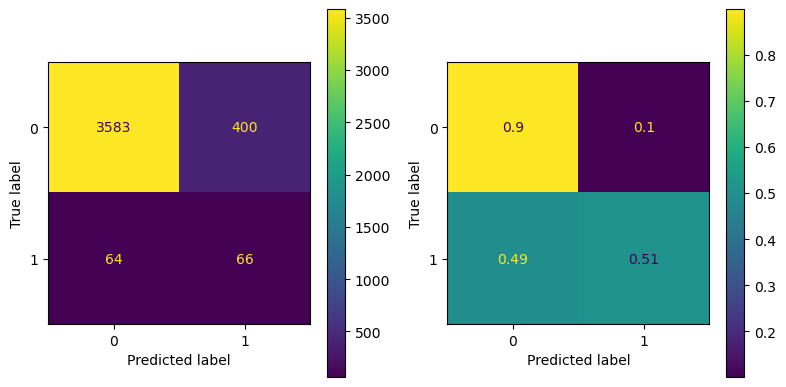

Model evaluation with val roc_auc_score:0.7646
roc_auc_score: 0.7722
f1_score: 0.0978
accuracy_score: 0.5291
recall_score: 0.8077


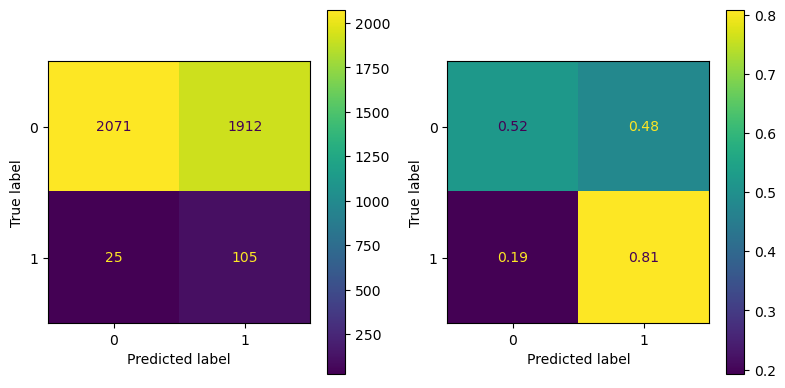

Model evaluation with val recall_score:0.8525
roc_auc_score: 0.7529
f1_score: 0.0795
accuracy_score: 0.3805
recall_score: 0.8462


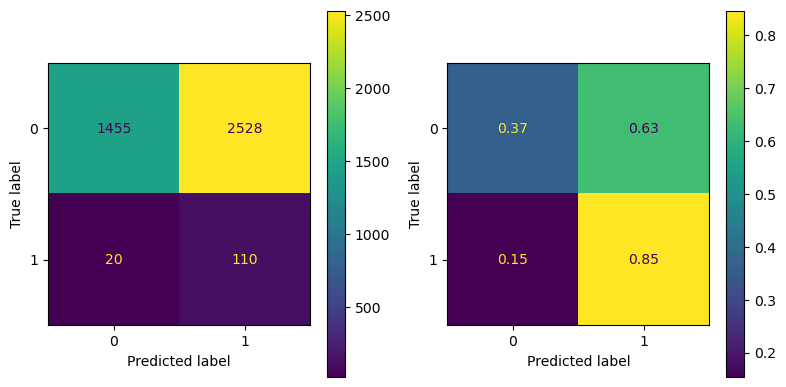

In [7]:
for i, (metric, (model, score)) in enumerate(best_gcn_model.items()):
  fig, axs = plt.subplots(1, 2, figsize=(8, 4))
  metrics, cms = evaluate_model(model, test_feat)
  print(f'Model evaluation with val {metric}:{score:.4f}')
  print_dict(metrics, '\n')
  
  for ax, cm in zip(axs, cms): cm.plot(ax=ax)
  plt.tight_layout() 
  plt.show()

### AttentiveFP

In [8]:
afp_model = lambda optimizer=None: dc.models.AttentiveFPModel(
  mode='classification',
  n_tasks=1,
  learning_rate=0.001,
  device=torch.device('cuda'),
  optimizer=optimizer
)
best_afp_model = train_model(afp_model, train_feat, val_feat, transformer, save_dir='checkpoints/AtentiveFP')

100%|██████████| 450/450.0 [00:32<00:00, 13.89it/s]


roc_auc_score: 0.7058, f1_score: 0.0958, accuracy_score: 0.7041, recall_score: 0.5945, train_loss: 0.8165, epoch: 0.0000


100%|██████████| 450/450.0 [00:31<00:00, 14.11it/s]


roc_auc_score: 0.7249, f1_score: 0.0909, accuracy_score: 0.6427, recall_score: 0.6774, train_loss: 0.7591, epoch: 1.0000


100%|██████████| 450/450.0 [00:31<00:00, 14.07it/s]


roc_auc_score: 0.7037, f1_score: 0.0973, accuracy_score: 0.6955, recall_score: 0.6221, train_loss: 0.7244, epoch: 2.0000


100%|██████████| 450/450.0 [00:31<00:00, 14.13it/s]


roc_auc_score: 0.7310, f1_score: 0.1049, accuracy_score: 0.7242, recall_score: 0.6129, train_loss: 0.7029, epoch: 3.0000


100%|██████████| 450/450.0 [00:34<00:00, 13.00it/s]


roc_auc_score: 0.7213, f1_score: 0.1292, accuracy_score: 0.8149, recall_score: 0.5207, train_loss: 0.6821, epoch: 4.0000


100%|██████████| 450/450.0 [00:50<00:00,  8.87it/s]


roc_auc_score: 0.7333, f1_score: 0.0978, accuracy_score: 0.6816, recall_score: 0.6544, train_loss: 0.6557, epoch: 5.0000


100%|██████████| 450/450.0 [00:52<00:00,  8.58it/s]


roc_auc_score: 0.7418, f1_score: 0.1001, accuracy_score: 0.6941, recall_score: 0.6452, train_loss: 0.6334, epoch: 6.0000


100%|██████████| 450/450.0 [00:52<00:00,  8.55it/s]


roc_auc_score: 0.7440, f1_score: 0.0951, accuracy_score: 0.6575, recall_score: 0.6820, train_loss: 0.6141, epoch: 7.0000


100%|██████████| 450/450.0 [00:51<00:00,  8.67it/s]


roc_auc_score: 0.7461, f1_score: 0.1338, accuracy_score: 0.8063, recall_score: 0.5668, train_loss: 0.5853, epoch: 8.0000


100%|██████████| 450/450.0 [00:53<00:00,  8.44it/s]


roc_auc_score: 0.7431, f1_score: 0.1815, accuracy_score: 0.8783, recall_score: 0.5115, train_loss: 0.5711, epoch: 9.0000


100%|██████████| 450/450.0 [00:52<00:00,  8.52it/s]


roc_auc_score: 0.7310, f1_score: 0.1004, accuracy_score: 0.6907, recall_score: 0.6544, train_loss: 0.5526, epoch: 10.0000


100%|██████████| 450/450.0 [00:53<00:00,  8.45it/s]


roc_auc_score: 0.7656, f1_score: 0.1541, accuracy_score: 0.8359, recall_score: 0.5668, train_loss: 0.5315, epoch: 11.0000


100%|██████████| 450/450.0 [00:49<00:00,  9.02it/s]


roc_auc_score: 0.7315, f1_score: 0.1452, accuracy_score: 0.8268, recall_score: 0.5576, train_loss: 0.5047, epoch: 12.0000


100%|██████████| 450/450.0 [00:53<00:00,  8.45it/s]


roc_auc_score: 0.7615, f1_score: 0.1337, accuracy_score: 0.8046, recall_score: 0.5714, train_loss: 0.4827, epoch: 13.0000


100%|██████████| 450/450.0 [00:52<00:00,  8.54it/s]


roc_auc_score: 0.7357, f1_score: 0.1474, accuracy_score: 0.8452, recall_score: 0.5069, train_loss: 0.4562, epoch: 14.0000


100%|██████████| 450/450.0 [00:51<00:00,  8.67it/s]


roc_auc_score: 0.7602, f1_score: 0.1686, accuracy_score: 0.8669, recall_score: 0.5115, train_loss: 0.4253, epoch: 15.0000


100%|██████████| 450/450.0 [00:52<00:00,  8.50it/s]


roc_auc_score: 0.7206, f1_score: 0.1152, accuracy_score: 0.7722, recall_score: 0.5622, train_loss: 0.4069, epoch: 16.0000


100%|██████████| 450/450.0 [00:52<00:00,  8.57it/s]


roc_auc_score: 0.7449, f1_score: 0.1243, accuracy_score: 0.7876, recall_score: 0.5714, train_loss: 0.3956, epoch: 17.0000


100%|██████████| 450/450.0 [00:52<00:00,  8.54it/s]


roc_auc_score: 0.7737, f1_score: 0.1791, accuracy_score: 0.8796, recall_score: 0.4977, train_loss: 0.3508, epoch: 18.0000


100%|██████████| 450/450.0 [00:53<00:00,  8.45it/s]


roc_auc_score: 0.7283, f1_score: 0.1165, accuracy_score: 0.7695, recall_score: 0.5760, train_loss: 0.3327, epoch: 19.0000


Model evaluation with val f1_score:0.1815
roc_auc_score: 0.7256
f1_score: 0.1716
accuracy_score: 0.8497
recall_score: 0.4923


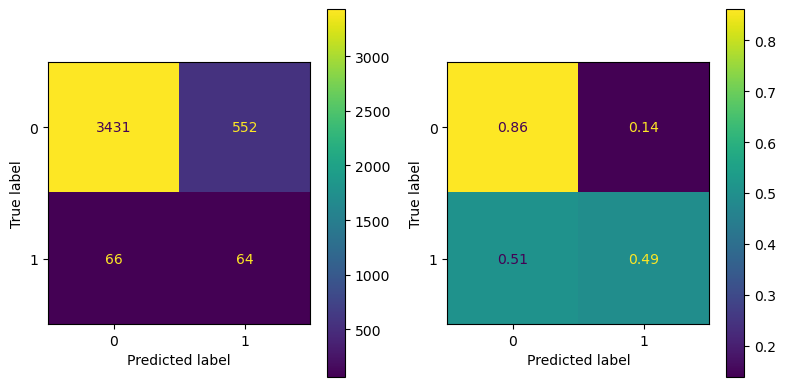

Model evaluation with val roc_auc_score:0.7737
roc_auc_score: 0.7671
f1_score: 0.2161
accuracy_score: 0.8818
recall_score: 0.5154


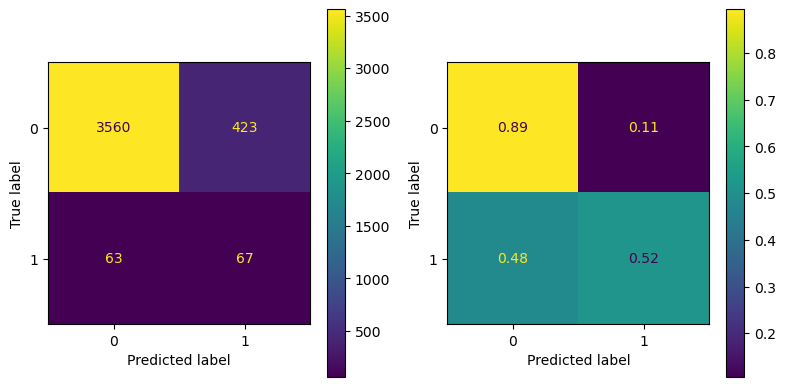

Model evaluation with val recall_score:0.6820
roc_auc_score: 0.7474
f1_score: 0.1179
accuracy_score: 0.6470
recall_score: 0.7462


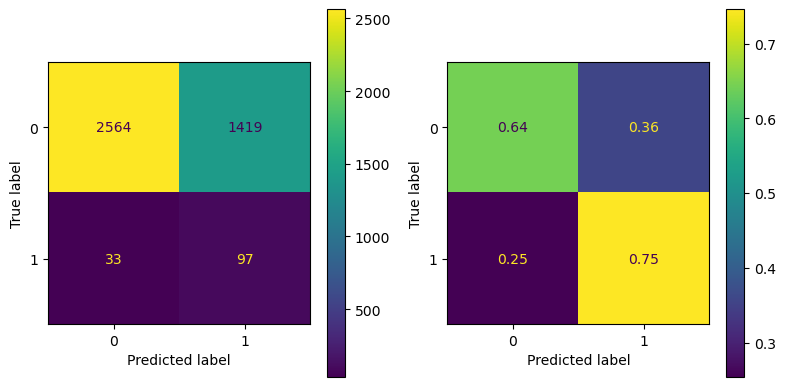

In [9]:
for i, (metric, (model, score)) in enumerate(best_afp_model.items()):
  fig, axs = plt.subplots(1, 2, figsize=(8, 4))
  metrics, cms = evaluate_model(model, test_feat)
  print(f'Model evaluation with val {metric}:{score:.4f}')
  print_dict(metrics, '\n')
  
  for ax, cm in zip(axs, cms): cm.plot(ax=ax)
  plt.tight_layout() 
  plt.show()

### GAT

In [10]:
gat_model = lambda optimizer=None: dc.models.GATModel(
  mode='classification',
  n_tasks=1,
  learning_rate=0.001,
  device=torch.device('cuda'),
  optimizer=optimizer
)
best_gat_model = train_model(gat_model, train_feat, val_feat, transformer, save_dir='checkpoints/GAT')

100%|██████████| 450/450.0 [00:34<00:00, 13.15it/s]


roc_auc_score: 0.6917, f1_score: 0.0724, accuracy_score: 0.4983, recall_score: 0.7419, train_loss: 0.8295, epoch: 0.0000


100%|██████████| 450/450.0 [00:34<00:00, 13.17it/s]


roc_auc_score: 0.7114, f1_score: 0.0764, accuracy_score: 0.5357, recall_score: 0.7281, train_loss: 0.7965, epoch: 1.0000


100%|██████████| 450/450.0 [00:32<00:00, 13.69it/s]


roc_auc_score: 0.6957, f1_score: 0.1288, accuracy_score: 0.8388, recall_score: 0.4516, train_loss: 0.7702, epoch: 2.0000


100%|██████████| 450/450.0 [00:34<00:00, 13.20it/s]


roc_auc_score: 0.7166, f1_score: 0.0772, accuracy_score: 0.5235, recall_score: 0.7558, train_loss: 0.7684, epoch: 3.0000


100%|██████████| 450/450.0 [00:19<00:00, 22.87it/s]


roc_auc_score: 0.7162, f1_score: 0.1172, accuracy_score: 0.7913, recall_score: 0.5253, train_loss: 0.7527, epoch: 4.0000


100%|██████████| 450/450.0 [00:17<00:00, 25.19it/s]


roc_auc_score: 0.6999, f1_score: 0.1167, accuracy_score: 0.7903, recall_score: 0.5253, train_loss: 0.7419, epoch: 5.0000


100%|██████████| 450/450.0 [00:17<00:00, 25.20it/s]


roc_auc_score: 0.6907, f1_score: 0.1108, accuracy_score: 0.7718, recall_score: 0.5392, train_loss: 0.7417, epoch: 6.0000


100%|██████████| 450/450.0 [00:17<00:00, 25.43it/s]


roc_auc_score: 0.7114, f1_score: 0.0915, accuracy_score: 0.6550, recall_score: 0.6590, train_loss: 0.7227, epoch: 7.0000


100%|██████████| 450/450.0 [00:17<00:00, 25.29it/s]


roc_auc_score: 0.7037, f1_score: 0.1015, accuracy_score: 0.7222, recall_score: 0.5945, train_loss: 0.7197, epoch: 8.0000


100%|██████████| 450/450.0 [00:17<00:00, 25.23it/s]


roc_auc_score: 0.7271, f1_score: 0.0855, accuracy_score: 0.6020, recall_score: 0.7051, train_loss: 0.7195, epoch: 9.0000


100%|██████████| 450/450.0 [00:17<00:00, 25.42it/s]


roc_auc_score: 0.7077, f1_score: 0.0868, accuracy_score: 0.6343, recall_score: 0.6590, train_loss: 0.7142, epoch: 10.0000


100%|██████████| 450/450.0 [00:17<00:00, 25.33it/s]


roc_auc_score: 0.6750, f1_score: 0.1271, accuracy_score: 0.8347, recall_score: 0.4562, train_loss: 0.7080, epoch: 11.0000


100%|██████████| 450/450.0 [00:18<00:00, 24.12it/s]


roc_auc_score: 0.6799, f1_score: 0.1091, accuracy_score: 0.7796, recall_score: 0.5115, train_loss: 0.7043, epoch: 12.0000


100%|██████████| 450/450.0 [00:18<00:00, 24.63it/s]


roc_auc_score: 0.7192, f1_score: 0.1084, accuracy_score: 0.7419, recall_score: 0.5945, train_loss: 0.6877, epoch: 13.0000


100%|██████████| 450/450.0 [00:17<00:00, 25.37it/s]


roc_auc_score: 0.6748, f1_score: 0.1276, accuracy_score: 0.8321, recall_score: 0.4654, train_loss: 0.6837, epoch: 14.0000


100%|██████████| 450/450.0 [00:17<00:00, 25.39it/s]


roc_auc_score: 0.7290, f1_score: 0.0942, accuracy_score: 0.6610, recall_score: 0.6682, train_loss: 0.6700, epoch: 15.0000


100%|██████████| 450/450.0 [00:17<00:00, 25.48it/s]


roc_auc_score: 0.7272, f1_score: 0.1373, accuracy_score: 0.8228, recall_score: 0.5346, train_loss: 0.6666, epoch: 16.0000


100%|██████████| 450/450.0 [00:17<00:00, 25.09it/s]


roc_auc_score: 0.7135, f1_score: 0.1104, accuracy_score: 0.7453, recall_score: 0.5991, train_loss: 0.6439, epoch: 17.0000


100%|██████████| 450/450.0 [00:17<00:00, 25.09it/s]


roc_auc_score: 0.7332, f1_score: 0.1187, accuracy_score: 0.7797, recall_score: 0.5622, train_loss: 0.6363, epoch: 18.0000


100%|██████████| 450/450.0 [00:17<00:00, 25.11it/s]


roc_auc_score: 0.7433, f1_score: 0.1137, accuracy_score: 0.7364, recall_score: 0.6406, train_loss: 0.6322, epoch: 19.0000


Model evaluation with val f1_score:0.1373
roc_auc_score: 0.7731
f1_score: 0.1593
accuracy_score: 0.8050
recall_score: 0.5846


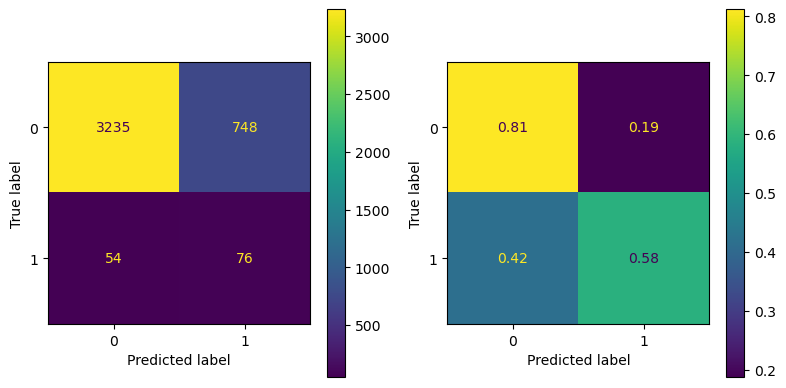

Model evaluation with val roc_auc_score:0.7433
roc_auc_score: 0.7694
f1_score: 0.1341
accuracy_score: 0.7362
recall_score: 0.6462


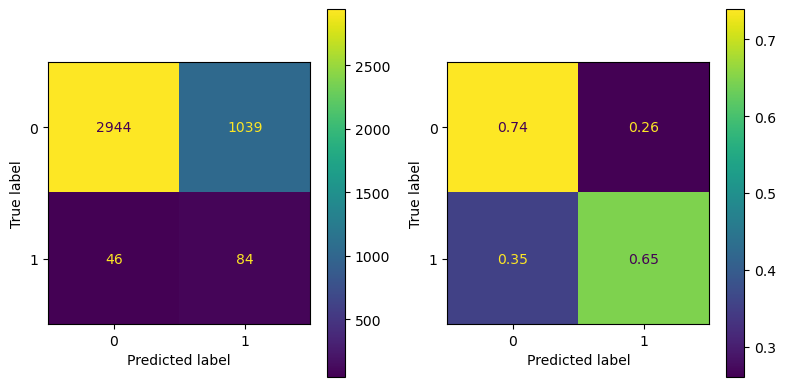

Model evaluation with val recall_score:0.7558
roc_auc_score: 0.7506
f1_score: 0.0978
accuracy_score: 0.5784
recall_score: 0.7231


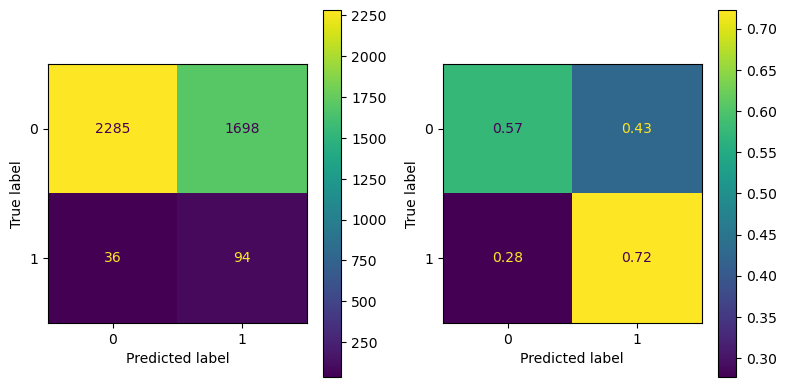

In [11]:
for i, (metric, (model, score)) in enumerate(best_gat_model.items()):
  fig, axs = plt.subplots(1, 2, figsize=(8, 4))
  metrics, cms = evaluate_model(model, test_feat)
  print(f'Model evaluation with val {metric}:{score:.4f}')
  print_dict(metrics, '\n')
  
  for ax, cm in zip(axs, cms): cm.plot(ax=ax)
  plt.tight_layout() 
  plt.show()